In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Ridge
import pandas as pd
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [ ]:
data = pd.read_csv("/content/data.csv")

In [ ]:
data[['description', 'interest_score']]

,description,interest_score
0,3번 착용했고 하자나 얼룩 없습니다!,0.07
1,시착후 보관중입니당 pk 롱슬리브 스트라이프 블루,0.24
2,"M사이즈 실착 1회 하자, 오염 없습니다 오후 5시 이전 결제 -> 택배 당일접수...",0.14
3,스타일이 바뀌어 판매합니다,0.05
4,노스텔지아 가디건 구버전 제품입니다 실사는 번톡주세요,0.08
...,...,...
50475,💒 국내 백화점구매 직장인인데 캐쥬얼 좋아해 사놓고 활용못해서 겹치는 스타일들 비움...,0.03
50476,폴로 후드집업 판매합니다! 구매할때 10만원정도로 구매했습니다,0.07
50477,사용감 많지 않아요~ 스판기도 약간 있어서 편해요 정품입니다 실측 허리단면 37...,0.07
50478,"✅ 교신,에눌,할인,흥정 등 메세지엔 답변 안하고 있으며 또한 결제 진행 중 연락두...",0.03


In [ ]:
# TF-IDF 벡터화
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X = vectorizer.fit_transform(data['description'].astype(str))

# 관심도 회귀 모델 학습 (Ridge 회귀로 과적합 방지)
y = data['interest_score']
model = Ridge(alpha=1.0)
model.fit(X, y)

# 단어별 영향력 확인
feature_names = vectorizer.get_feature_names_out()
coefs = model.coef_

# 영향력이 큰 단어 Top 30 출력
coef_df = pd.DataFrame({'word': feature_names, 'coef': coefs})
top_words = coef_df.sort_values(by='coef', ascending=False).head(30)
print(top_words)


                          word      coef
4486                    트랙탑입니다  0.128816
4370                    코디하기좋고  0.099333
1609                        만든  0.092902
3191                    예민하신분들  0.090861
2591                        설정  0.085988
660                       가져가는  0.082655
4623                      포장해서  0.077309
4260                      추가사진  0.076960
523                        rib  0.076085
586   ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ  0.074645
3266                        오프  0.074640
3695                     장바구니에  0.074533
4615                      포인트가  0.074185
4542                  판매하고있습니다  0.073821
1262                        다를  0.073487
455                         ex  0.071529
910                        구경해  0.070471
3561                        임자  0.069458
4272                     추천드리며  0.069296
4223                      총장길이  0.068906
514                         pk  0.068186
3259                    오차범위있음  0.067945
2289                       사람이  0.067896
4807            

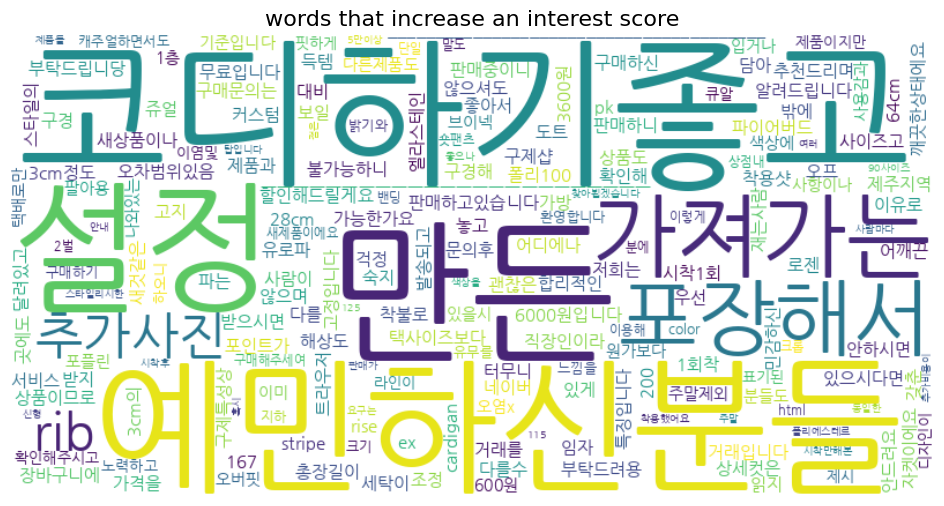

In [ ]:
word_weights_filtered = {
    row['word']: row['coef']
    for _, row in coef_df.iterrows()
    if row['coef'] > 0 and row['word'] != '트랙탑입니다'
}

wc = WordCloud(
    font_path=font_path,
    background_color='white',
    width=800,
    height=400
).generate_from_frequencies(word_weights_filtered)

# 3. 시각화
plt.figure(figsize=(12, 6))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title("words that increase an interest score", fontsize=16)
plt.show()


In [ ]:
import torch
from torch import nn
from transformers import BertTokenizer
from transformers import BertModel
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np

tokenizer = BertTokenizer.from_pretrained("beomi/kcbert-base")
bert = BertModel.from_pretrained("beomi/kcbert-base")

# Dataset 정의
class BERTDataset(Dataset):
    def __init__(self, texts, targets, tokenizer, max_len=64):
        self.texts = texts
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        target = self.targets[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'target': torch.tensor(target, dtype=torch.float)
        }

# 회귀용 BERT 모델 정의
class KoBERTRegressor(nn.Module):
    def __init__(self, bert):
        super().__init__()
        self.bert = bert
        self.dropout = nn.Dropout(0.3)
        self.regressor = nn.Linear(768, 1)

    def forward(self, input_ids, attention_mask):
        output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = output.pooler_output  # [CLS] 토큰
        x = self.dropout(pooled_output)
        return self.regressor(x).squeeze(1)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/619 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

In [ ]:
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# 데이터 준비
df = data.dropna(subset=['description', 'interest_score'])  # 누락 제거
train_texts, val_texts, train_targets, val_targets = train_test_split(
    df['description'], df['interest_score'], test_size=0.2, random_state=42
)

# Dataset & Dataloader 구성
train_dataset = BERTDataset(train_texts.tolist(), train_targets.tolist(), tokenizer)
val_dataset = BERTDataset(val_texts.tolist(), val_targets.tolist(), tokenizer)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

# 모델, 손실함수, 옵티마이저
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = KoBERTRegressor(bert).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

# 학습 루프
EPOCHS = 3
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for batch in tqdm(train_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        targets = batch['target'].to(device)

        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{EPOCHS} - Train Loss: {avg_loss:.4f}")


100%|██████████| 1262/1262 [07:50<00:00,  2.68it/s]


Epoch 1/3 - Train Loss: 0.0138


100%|██████████| 1262/1262 [07:40<00:00,  2.74it/s]


Epoch 2/3 - Train Loss: 0.0053


100%|██████████| 1262/1262 [07:38<00:00,  2.75it/s]

Epoch 3/3 - Train Loss: 0.0047


In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

model.eval()
val_preds = []
val_targets_all = []

with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        targets = batch['target'].to(device)

        outputs = model(input_ids, attention_mask)
        val_preds.extend(outputs.cpu().numpy())
        val_targets_all.extend(targets.cpu().numpy())

val_preds = np.array(val_preds)
val_targets_all = np.array(val_targets_all)

val_mse = mean_squared_error(val_targets_all, val_preds)
val_r2 = r2_score(val_targets_all, val_preds)

print(f"Validation MSE: {val_mse:.4f}")


Validation MSE: 0.0030


In [ ]:
import shap

# ✅ BERT 임베딩 레이어 추출
embedding_layer = model.bert.embeddings

# ✅ 텍스트 → input_ids → embedding 통과 → float tensor 반환
def get_embeddings(texts):
    enc = tokenizer(
        texts,
        return_tensors='pt',
        truncation=True,
        padding='max_length',
        max_length=128
    ).to(device)

    # ❗ 임베딩 통과시키면 float32 반환됨
    with torch.no_grad():
        embedded = embedding_layer(input_ids=enc['input_ids'])
    return embedded

# ✅ background, sample 준비
background_texts = df['description'].dropna().astype(str).sample(10, random_state=42).tolist()
sample_texts = df['description'].dropna().astype(str).sample(2, random_state=0).tolist()

background_inputs = get_embeddings(background_texts)
sample_inputs = get_embeddings(sample_texts)

import torch.nn as nn
# ✅ DummyModel 정의
class DummyModel(nn.Module):
    def __init__(self, regressor):
        super().__init__()
        self.regressor = regressor

    def forward(self, embedding_input):
        return self.regressor(embedding_input.mean(dim=1))  # [B, L, D] → [B, D] → [B, 1]

# ✅ 인스턴스 생성 (regressor만 넣음)
dummy_model = DummyModel(model.regressor)


# ✅ SHAP explainer
explainer = shap.DeepExplainer(dummy_model, background_inputs)
shap_values = explainer.shap_values(sample_inputs)


In [ ]:
import shap
import torch
from torch import nn
from transformers import BertTokenizer, BertModel

# 1. Tokenizer & BERT 불러오기 (CPU 기준)
tokenizer = BertTokenizer.from_pretrained("beomi/kcbert-base")
bert = BertModel.from_pretrained("beomi/kcbert-base").cpu()

# 2. 회귀 모델 정의
class KoBERTRegressor(nn.Module):
    def __init__(self, bert):
        super().__init__()
        self.bert = bert
        self.dropout = nn.Dropout(0.3)
        self.regressor = nn.Linear(768, 1)

    def forward(self, input_ids, attention_mask):
        output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = output.pooler_output
        x = self.dropout(pooled_output)
        return self.regressor(x)

# 3. 모델 로딩 (CPU)
model = KoBERTRegressor(bert).cpu()
model.eval()

# 4. 샘플 문장 준비
sample_texts = [
    "가성비 좋고 품질도 괜찮아서 바로 샀어요",
    "가격은 조금 비싼 편이지만 디자인이 예뻐요",
    "배송도 빠르고 생각보다 훨씬 만족스러워요"
]

# 5. SHAP용 Custom forward 함수
def predict(texts):
    # 💥 리스트 내 요소를 str로 강제 변환
    texts = [str(t) for t in texts]

    encoded = tokenizer(
        texts,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=64
    )
    input_ids = encoded["input_ids"]
    attention_mask = encoded["attention_mask"]

    with torch.no_grad():
        preds = model(input_ids, attention_mask).squeeze(1)
    return preds.unsqueeze(1)


# 6. SHAP Explainer 구성 (tokenizer 기반 마스커)
masker = shap.maskers.Text(tokenizer)
explainer = shap.Explainer(predict, masker=masker, algorithm="partition")

# 7. SHAP 값 계산
shap_values = explainer(sample_texts)

# 8. 시각화
for i, text in enumerate(sample_texts):
    print(f"🧾 문장 {i+1}: {text}")
    shap.plots.text(shap_values[i])




PartitionExplainer explainer: 4it [00:15,  7.67s/it]

🧾 문장 1: 가성비 좋고 품질도 괜찮아서 바로 샀어요


🧾 문장 2: 가격은 조금 비싼 편이지만 디자인이 예뻐요


🧾 문장 3: 배송도 빠르고 생각보다 훨씬 만족스러워요
